# Simple Image Processing

In this project, we will use `OpenCV` to perform some simple image processing. We will cover how to load an image using different color spaces, how to crop/scale an image and how to apply various transformations. At the end, we will talk a little bit about filtering, but that is a much bigger topic and deserves a separate notebook.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

First of all, we load our image using `OpenCV`. By default, the image loaded will be a `numpy` array using BGR. To display it using `matplotlib`, we need to convert it back to RGB first.

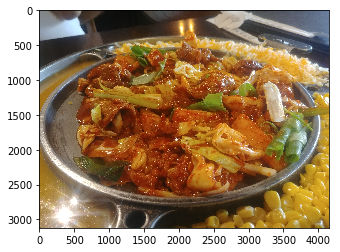

In [2]:
image = cv2.imread('korean.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image);

In [3]:
type(image)

numpy.ndarray

In [4]:
image.shape

(3120, 4160, 3)

In computer vision, it is very common to work with grayscale image. When displaying a grayscale image using `matplotlib`, we need to specify the argument `cmap`.

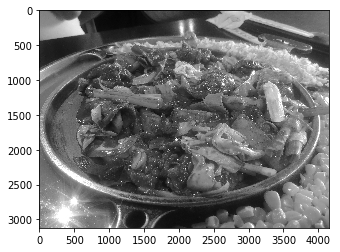

In [5]:
image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

plt.imshow(image_gray, cmap='gray');

HSV is another popular colorspace. This is especially useful because it is less vulnerable to lighting condition.

As an example, let say we want to detect all the yellow objects in our image. The RGB value of yellow is (0, 255, 255). The food around the iron plate (corn, cheese, egg) all appear to be yellow.

In [6]:
lower_yellow = np.array([135, 135, 0])
upper_yellow = np.array([255, 255, 120])

mask = cv2.inRange(image, lower_yellow, upper_yellow)

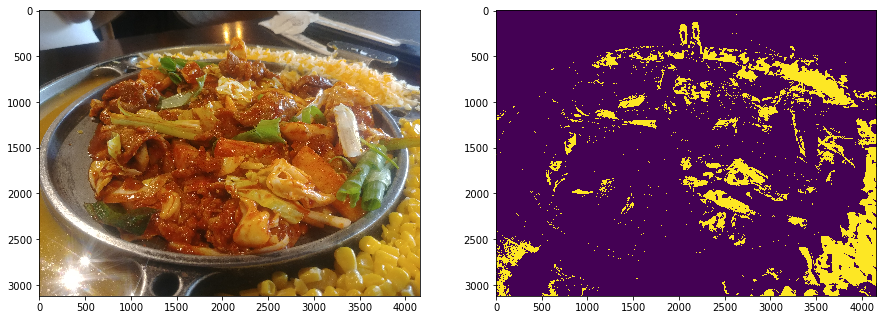

In [7]:
plt.figure(figsize=(15, 8))
plt.subplot(121)
plt.imshow(image)
plt.subplot(122)
plt.imshow(mask);

It is able to capture the corn (bottom-right corner) and the cheese (top), but not quite the egg (left). Although we have used a wide range for the RGB value, but the lighting condition (bright/dim) could harm the detection a lot.

Now let's try it again with HSV color space. First of all, let's get the HSV value for yellow:

In [8]:
print(cv2.cvtColor(np.uint8([[[255, 255, 0]]]), cv2.COLOR_RGB2HSV))

[[[ 30 255 255]]]


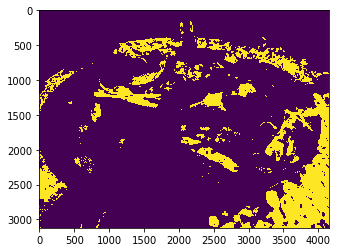

In [9]:
lower_yellow_hsv = np.array([20, 100, 100])
upper_yellow_hsv = np.array([40, 255, 255])
image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

mask_hsv = cv2.inRange(image_hsv, lower_yellow_hsv, upper_yellow_hsv)
plt.imshow(mask_hsv);

It certainly does a better job capturing the yellowish food around the plate!

## Cropping/Scaling Images

When we work on image dataset, different images would have different sizes. For some machine learning model, it is necessary to have a fixed input size. For example, maybe we have to scale our image into 1000 x 1000 pixels for our CNN.

Since `OpenCV` reads our image as a `numpy` array, we can use slicing to obtain a sub-image:

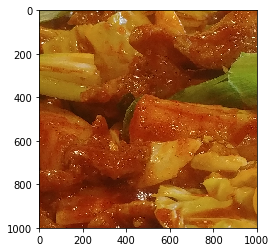

In [10]:
image_corner_crop = image[1000:2000, 1500:2500, :]

plt.imshow(image_corner_crop);

By doing so, we preserve the actual ratio of the elements in the image. But we also sacrifice a lot of important elements in the image. Another alternative would be scaling:

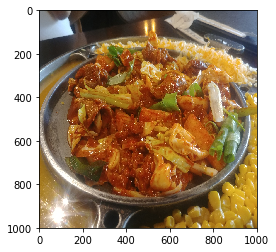

In [11]:
image_resize = cv2.resize(image, (1000, 1000))

plt.imshow(image_resize);

## Affine Transformation

Before explaining what is an affine transformation, we first need to understand how pixels are identified in a coordinate system. A pixel $\mathbf{x}=(x, y)$ can be located using two coordinates, where the top-left corner is usually taken to be the origin $(0, 0)$. For example, here is the pixel $(1500, 2500)$ in our picture:

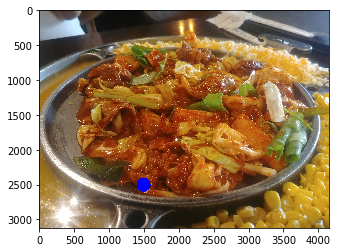

In [12]:
example = image.copy()
cv2.circle(example, (1500, 2500), 100, (0, 0, 255), -1)

plt.imshow(example);

The most elementary example of an affine transformation is **translation**. It translates the $(x, y)$ pixel to $(x+t_x, y+t_y)$ where $t_x$ and $t_y$ are some fixed numbers we have chosen.

Mathematically, it is nicer to write the transformation in terms of matrix multiplication. The translation matrix is given by
$$T=\begin{bmatrix}1 & 0 & t_x\\ 0& 1& t_y\end{bmatrix}.$$
To multiply it with a pixel coordinate $\mathbf{x}=(x, y)$, we have to first form the **augmented vector** $\overline{\mathbf{x}}=(x, y, 1)$ by putting an extra 1 at the end. Then
$$T(\overline{\mathbf{x}})=\begin{bmatrix}1 & 0 & t_x\\ 0& 1& t_y\end{bmatrix}
\begin{bmatrix}
x\\
y\\
1
\end{bmatrix}
=
\begin{bmatrix}
x+0+t_x\\
0+y+t_y
\end{bmatrix}
=\begin{bmatrix}
x+t_x\\
y+t_y
\end{bmatrix}.
$$
Here is how we can do it with `OpenCV`: (note that the translation matrix is again 2x3 rather just two numbers $t_x, t_y$)

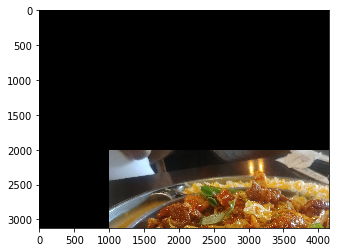

In [13]:
T = np.float32([[1, 0, 1000], [0, 1, 2000]]) # t_x = 1000, t_y = 2000
image_translate = cv2.warpAffine(image, T, (image.shape[1], image.shape[0]))

plt.imshow(image_translate);

Another important example is **rotation**. The rotation matrix for rotating by an angle $\theta$ is given by
$$
R=\begin{bmatrix}
\cos(\theta) & -\sin(\theta) & 0\\
\sin(\theta) & \cos(\theta) & 0
\end{bmatrix}.
$$

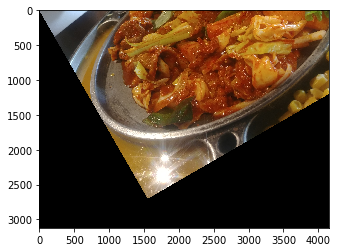

In [14]:
R = cv2.getRotationMatrix2D((0, 0), 30, 1) # rotate by 30 degrees, with scaling factor 1
image_rotate = cv2.warpAffine(image, R, (image.shape[1], image.shape[0]))

plt.imshow(image_rotate);

If we want to compose two translations: for example, if we want to do a rotation $R$ followed by a translation $T$, we can obtain the composition by adding an extra row $\begin{bmatrix}0 & 0 & 1\end{bmatrix}$ below $R$ and $T$, followed with a matrix multiplication:
$$
\begin{bmatrix}1 & 0 & t_x\\ 0& 1& t_y\\ 0 & 0 & 1\end{bmatrix}
\begin{bmatrix}
\cos(\theta) & -\sin(\theta) & 0\\ \sin(\theta) & \cos(\theta) & 0\\ 0 & 0 & 1
\end{bmatrix}
=
\begin{bmatrix}
\cos(\theta) & -\sin(\theta) & t_x\\
\sin(\theta) & \cos(\theta) & t_y\\
0 & 0 & 1
\end{bmatrix}
$$

Because of this reason, it motivates us to consider a even more general transformation
$$
A=\begin{bmatrix}
a_{00} & a_{01} & a_{02}\\
a_{10} & a_{10} & a_{20}
\end{bmatrix}.
$$
(We also add the row $\begin{bmatrix}0 & 0 & 1\end{bmatrix}$ if we wish to compute composition)

A transformation given by a matrix like this is called an **affine transformation**. Under such transformation, parallel lines would remain parallel. Another useful feature of affine transformation is that it allows us to map any three points to any three other locations we specified. (there might be some degenerate cases, but let's ignore it for now)

For example, let us specify three points in our image.

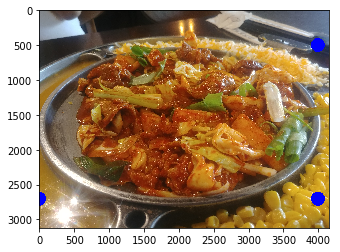

In [15]:
mark = image.copy()
cv2.circle(mark, (0, 2700), 100, (0, 0, 255), -1)
cv2.circle(mark, (4000, 500), 100, (0, 0, 255), -1)
cv2.circle(mark, (4000, 2700), 100, (0, 0, 255), -1)

plt.imshow(mark);

We can send these three points to the nearest corner. It should result in a vertical stretch of the original image. As a result, in the new image, it looks like the camera angle was from the top, but not from the side.

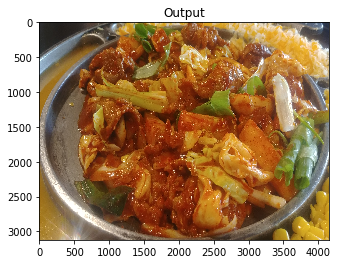

In [16]:
points_original = np.float32([[0, 2700], [4000, 500], [4000, 2700]])
points_after = np.float32([[0, image.shape[0]],
                           [image.shape[1], 0],
                           [image.shape[1], image.shape[0]]])

A = cv2.getAffineTransform(points_original, points_after)

dst = cv2.warpAffine(image, A, (image.shape[1], image.shape[0]))

plt.imshow(dst)
plt.title('Output');

## Perspective Transformation

In human vision, sometimes parallel lines do not look parallel - instead, it looks like they are converging to a point very far away. Here is an example:

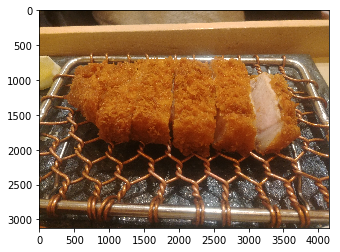

In [17]:
pic = cv2.imread('pork.jpg')
pic = cv2.cvtColor(pic, cv2.COLOR_BGR2RGB)
plt.imshow(pic);

The edges of the metal frame are supposed to be parallel, but they don't look like that in the image. Sometimes we want to fix this by "changing our perspective". How do we do that?

The solution to this is **perspective transformation**. It is little bit tricky to describe the math here, but basically it is given by a 3x3 matrix and everything is computed using **projective coordinates**. Such transformation doesn't preserve parallel lines, but straight lines would remain straight. And it allows us to take any four points to any four locations we desired.

In the following image, we are going to map the four blue dots to the four corners. Again, in the new image, it looks like we are looking from the top.

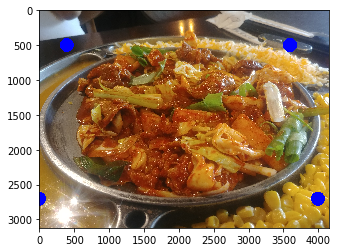

In [18]:
mark_proj = image.copy()
cv2.circle(mark_proj, (0, 2700), 100, (0, 0, 255), -1)
cv2.circle(mark_proj, (3600, 500), 100, (0, 0, 255), -1)
cv2.circle(mark_proj, (4000, 2700), 100, (0, 0, 255), -1)
cv2.circle(mark_proj, (400, 500), 100, (0, 0, 255), -1)

plt.imshow(mark_proj);

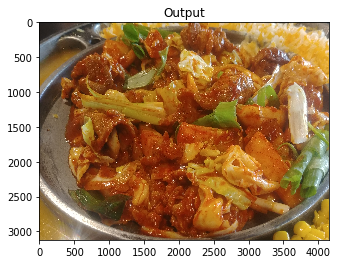

In [19]:
points_original = np.float32([[0, 2700], [3600, 500], [4000, 2700], [400, 500]])
points_after = np.float32([[0, image.shape[0]],
                           [image.shape[1], 0],
                           [image.shape[1], image.shape[0]],
                           [0, 0]])

P = cv2.getPerspectiveTransform(points_original, points_after)

dst = cv2.warpPerspective(image, P, (image.shape[1], image.shape[0]))

plt.imshow(dst)
plt.title('Output');

## Filtering

In image processing, sometimes it is helpful to apply a filter on it - it can create interesting visual effects, remove noise, or detect particular patterns.

Consider the following matrix/filter:

In [20]:
kernel_5 = np.ones((5, 5), np.float32) / 25
kernel_5

array([[0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04]], dtype=float32)

When we apply this filter to the image, then for each pixel, we will update the RGB value by taking the average of all 25 pixels around it. Because of the averaging, it "weakens" the color signal and the image is blurred.

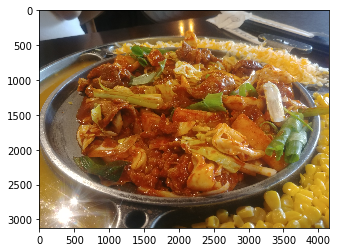

In [21]:
image_5 = cv2.filter2D(image, -1, kernel_5)
plt.imshow(image_5);

The effect is not quite significant since we only use a 5x5 filter. (Our image is very large in size) Let's increasing the size of our filter, and hence the effect of the averaging:

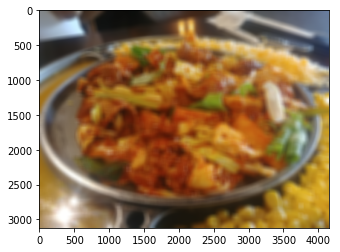

In [22]:
kernel_77 = np.ones((77, 77),np.float32)/(77 ** 2)
image_77 = cv2.filter2D(image, -1, kernel_77)
plt.imshow(image_77);

On the other hand, it is possible to sharpen our image by increasing the matrix entries in the filter. For example, consider:

In [23]:
kernel = np.float32([[-1, -1, -1], [-1, 10, -1], [-1, -1, -1]])
kernel

array([[-1., -1., -1.],
       [-1., 10., -1.],
       [-1., -1., -1.]], dtype=float32)

It would produce 10 times intensity for our RGB value in a pixel, minus some contributions from the surrounding pixels. Here is what it does:

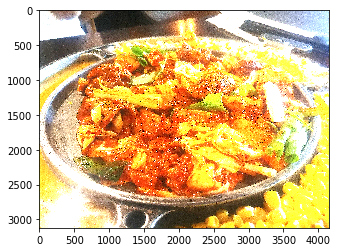

In [24]:
image_sharpen = cv2.filter2D(image, -1, kernel)
plt.imshow(image_sharpen);